In [25]:
# 25 May 2025
# https://www.kaggle.com/datasets/samithsachidanandan/countries-by-external-debt

<h1 style="line-height:3rem;"> External Debt </h1>

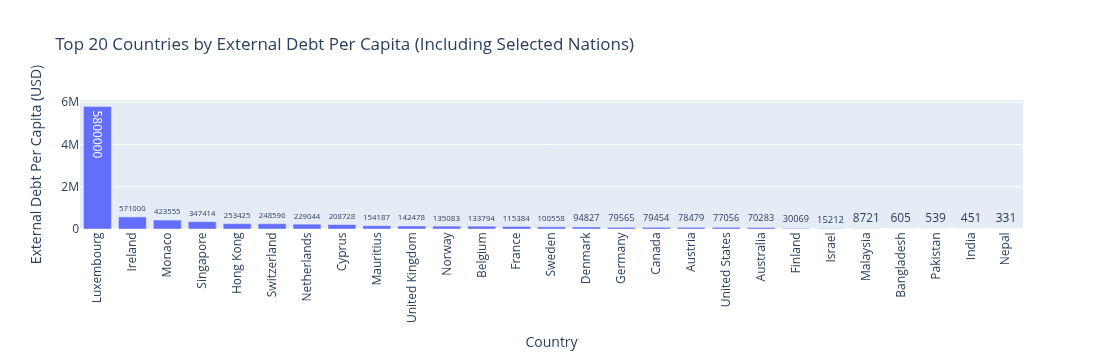

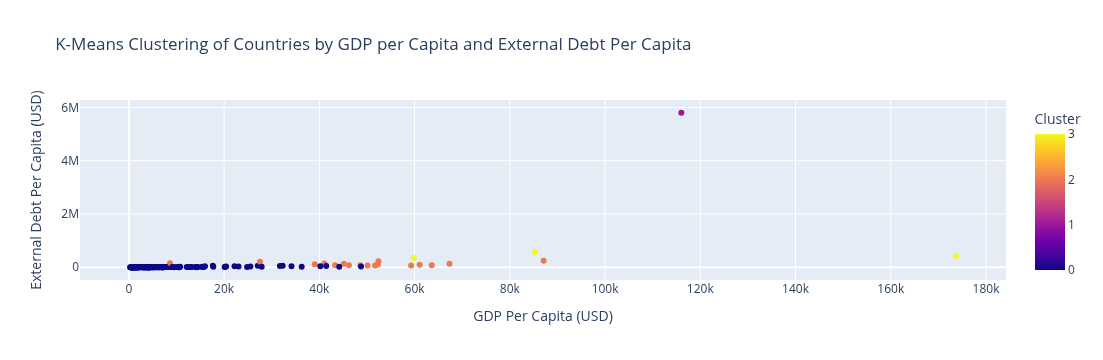

In [10]:
import pandas as pd
import plotly.express as px
from sklearn.cluster import KMeans
import numpy as np
import re

# ---------- Utility Functions ----------

def clean_numeric(value):
    if isinstance(value, str):
        value = re.sub(r'[^\d.]', '', value.replace(",", ""))
    try:
        return float(value)
    except:
        return None

def load_and_clean_external_debt(file_path):
    df = pd.read_csv(file_path)
    df['External_debt_per_capita'] = df['External_debt_per_capita '].apply(clean_numeric)
    df = df.rename(columns={"Location": "Country"})
    return df

def load_latest_gdp_per_capita(file_path):
    df = pd.read_csv(file_path)
    # Get latest year column (last numeric column)
    latest_year = df.columns[-2] if df.columns[-1].startswith("Unnamed") else df.columns[-1]
    df['GDP_per_capita_latest'] = df[latest_year]
    gdp_df = df[['Country Name', 'GDP_per_capita_latest']].rename(columns={"Country Name": "Country"})
    return gdp_df

# ---------- Plot Top N Debt Chart ----------

def plot_top_n_debt(df, top_n=20, include_countries=None):
    if include_countries is None:
        include_countries = []
    top_df = df.nlargest(top_n, 'External_debt_per_capita')
    include_df = df[df['Country'].isin(include_countries)]
    combined_df = pd.concat([top_df, include_df]).drop_duplicates(subset='Country')
    combined_df = combined_df.sort_values(by='External_debt_per_capita', ascending=False)

    fig = px.bar(combined_df,
                 x='Country',
                 y='External_debt_per_capita',
                 title=f"Top {top_n} Countries by External Debt Per Capita (Including Selected Nations)",
                 labels={'External_debt_per_capita': 'External Debt Per Capita (USD)'},
                 text='External_debt_per_capita')
    fig.update_layout(xaxis_tickangle=-90)
    fig.show()

# ---------- KMeans Clustering and Plot ----------

def plot_kmeans_cluster(df_debt, df_gdp, n_clusters=4):
    df = pd.merge(df_debt, df_gdp, on='Country', how='inner')
    df['GDP_per_capita_latest'] = df['GDP_per_capita_latest'].apply(clean_numeric)

    df = df.dropna(subset=['External_debt_per_capita', 'GDP_per_capita_latest'])

    X = df[['GDP_per_capita_latest', 'External_debt_per_capita']].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    df['Cluster'] = kmeans.fit_predict(X)

    fig = px.scatter(df,
                     x='GDP_per_capita_latest',
                     y='External_debt_per_capita',
                     color='Cluster',
                     hover_name='Country',
                     title='K-Means Clustering of Countries by GDP per Capita and External Debt Per Capita',
                     labels={
                         'GDP_per_capita_latest': 'GDP Per Capita (USD)',
                         'External_debt_per_capita': 'External Debt Per Capita (USD)'
                     })
    fig.show()

# ---------- Main Execution ----------

def main():
    external_debt_file = '../datasets/New/CountriesbyExternalDebtData.csv'
    gdp_file = '../datasets/New/gdp_per_capita.csv'
    include_countries = ["Finland", "Sweden", "Denmark", "Israel", "Norway", "Bangladesh", "Pakistan", "India", "Srilanka", "Nepal", "Malaysia"]

    df_debt = load_and_clean_external_debt(external_debt_file)
    df_gdp = load_latest_gdp_per_capita(gdp_file)

    plot_top_n_debt(df_debt, top_n=20, include_countries=include_countries)
    plot_kmeans_cluster(df_debt, df_gdp, n_clusters=4)

# Run the script
main()
